In [26]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from pathlib import Path
from datetime import date, timedelta
import re
import multiprocessing as mult
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from joblib import dump, load
import plotly.express as px

In [27]:
data = pd.read_feather('data_proc_ver_2.feather')

## Grouping by user

Since our main goal is to find any relation between the players we shall first analyze the distribution of the dataset by grouping by username.

In [28]:
usercount = data.groupby('Username').size()

In [29]:
usercount.describe()

count    977510.000000
mean          7.082411
std          19.708889
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1145.000000
dtype: float64

It seems that we have a mean of 7 games per username which might be significative but seeing the percentiles and the standard deviation it doesn't seen that we have had much luck and that there are users with a significant bulk of games and that the majority of players only have one game registered in our dataset. Basically our distribution is skewed most prominently in the first quantile.

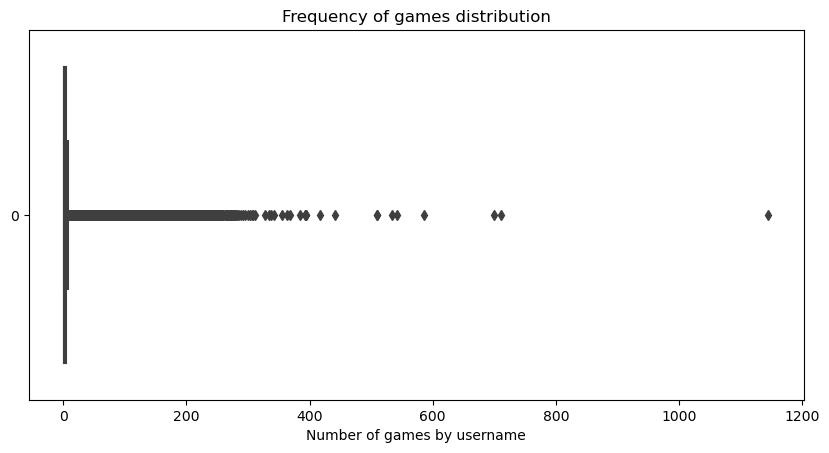

In [31]:
userdist = sns.boxplot(data = usercount, orient = 'h')
userdist.set_xlabel("Number of games by username")
userdist.set_title("Frequency of games distribution");
userdist.figure.set_figwidth(10);

Our suspicions have been confirmed, the distribution is very skewed.

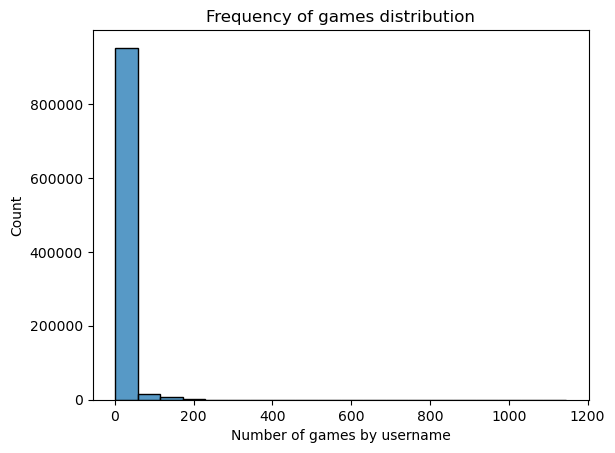

In [32]:
userdist = sns.histplot(data = usercount, bins = 20)
userdist.set_xlabel("Number of games by username")
userdist.set_title("Frequency of games distribution");
#userdist.figure.set_figwidth(60);

### Selecting the most representative candidates

Given this distribution we will first eliminate the first quantile of the set since we deem that one game is not representative enough of a person's behaviour.

In [7]:
userdf = pd.DataFrame()
userdf['Username'] = usercount.index
userdf['games'] = usercount.values

In [8]:
userdf = userdf.loc[userdf['games'] > 7]
userdf.describe()

,games
count,154536.000000
mean,33.858137
std,39.908842
min,8.000000
25%,10.000000
50%,17.000000
75%,37.000000
max,1145.000000


We seen to still have a very skewed distribution given the standard deviation and the percentiles.

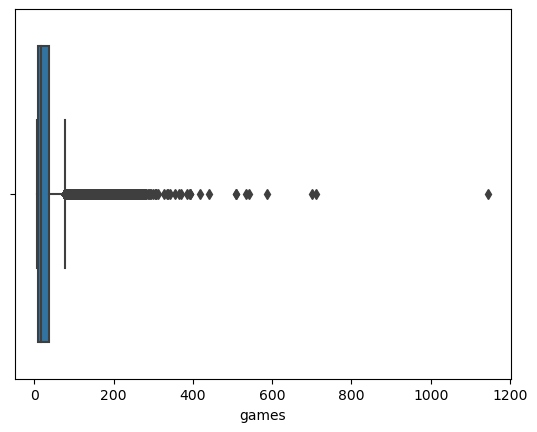

In [9]:
userdist = sns.boxplot(data = userdf, x = 'games')

As we can see after limiting the mininum number of games to 8 there's still quite a lot of points far from the mean.

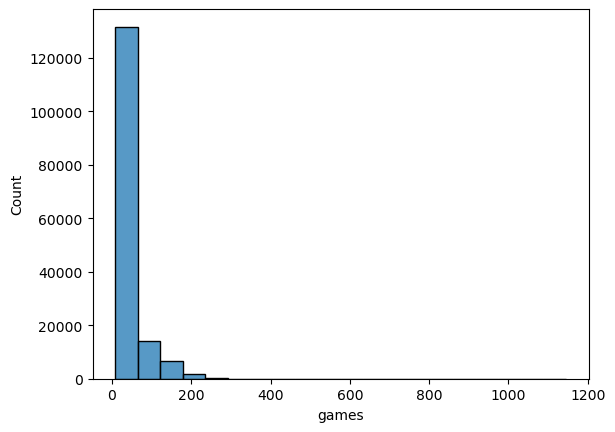

In [10]:
userdist = sns.histplot(data = userdf, x ='games', bins = 20)
#userdist.figure.set_figwidth(60);

Even though we still have skeweness the distribution seems much better. We will use this reduced dataset in our clustering algorithms.

### Generating the values for the kmeans

First we will create a new DataFrame where we will place all the variable that we will use to try to cluster the data.

In [11]:
data['attemps'] = data['Trial'].apply(lambda x: 6 if x == 7 else x)
data['ocurr'] = data.groupby('Username')['Username'].transform('size')
training_data = data.loc[data['ocurr'] > 7]
uservals = pd.DataFrame()
uservals['Username'] = training_data.groupby('Username')['Username'].size().index

### Generating the variables

First we will create some basic variables, the mean length of the game and the average of lost games.

In [12]:
uservals['Mean_length'] = training_data.groupby('Username')['attemps'].mean().values

In [13]:
def findlosses(series):
    loses = 0
    for val in series:
        if val == 7:
            loses +=1
    return loses/len(series)
uservals['Mean_loss'] = training_data.groupby('Username')['Trial'].apply(findlosses).values

In [14]:
#Optional
#def avgcharfirsttry(series, char):
#    total = 0
#    for game in series:
#        total += game[0].count(char)
#    return total/len(series)
#uservals['Mean_green_first'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharfirsttry(x, '🟩')).values
#uservals['Mean_yellow_first'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharfirsttry(x, '🟨')).values
#uservals['Mean_white_first'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharfirsttry(x, '⬜')).values

Now we will find the average number of tiles of a given color for a given user.

In [15]:
def avgcharpergame(series, char):
    avg = 0
    for game in series:
        total = 0
        for attempt in game:
            total += attempt.count(char)
        avg += total/len(game)
    return avg/len(series)
uservals['Mean_green'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharpergame(x, '🟩')).values
uservals['Mean_yellow'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharpergame(x, '🟨')).values
uservals['Mean_white'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharpergame(x, '⬜')).values

Finally we will generate the average of the differences between attemps of number of each color tile for each player.

In [16]:
def avgchardiff(series, char):
    avg = 0
    for game in series:
        total = 0
        if len(game) > 1:
            for i in range(0, len(game)-1):
                total += game[i+1].count(char) - game[i].count(char)
            avg += total/(len(game) - 1)
    return avg/len(series)
uservals['Mean_green_diff'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgchardiff(x, '🟩')).values
uservals['Mean_yellow_diff'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgchardiff(x, '🟨')).values
uservals['Mean_white_diff'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgchardiff(x, '⬜')).values

In [17]:
uservals

,Username,Mean_length,Mean_loss,Mean_green,Mean_yellow,Mean_white,Mean_green_diff,Mean_yellow_diff,Mean_white_diff
0,0000000a77,3.692308,0.076923,2.688462,0.597436,1.714103,1.312821,-0.224359,-1.088462
1,0001mz,3.529412,0.000000,2.211765,0.849020,1.939216,2.210784,-0.549020,-1.661765
2,000Dillinger,3.870370,0.000000,2.249691,0.680556,2.069753,1.800617,-0.522840,-1.277778
3,000GOOBY,3.653846,0.000000,2.463462,0.744231,1.792308,1.974359,-0.407692,-1.566667
4,000lliissaa000,4.923077,0.000000,2.116667,1.016667,1.866667,1.378205,-0.451282,-0.926923
...,...,...,...,...,...,...,...,...,...
154531,zzzmarie1,4.068966,0.000000,2.399425,0.600000,2.000575,1.608908,-0.295115,-1.313793
154532,zzzoren,4.090909,0.000000,2.336364,0.760354,1.903283,1.736869,-0.470707,-1.266162
154533,zzzsan,5.026316,0.000000,2.353947,0.755263,1.890789,1.198684,-0.276316,-0.922368
154534,zzzymmiT,2.666667,0.000000,2.607407,0.788889,1.603704,3.194444,-1.138889,-2.055556


## Clustering

First we will need to standarize our data, then we will perform the necessary transformations to it in order to fit it to the models. We will also create a dictionary containing the parameters for the K-means algorithm.

In [18]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [19]:
features = uservals.loc[:, uservals.columns != 'Username']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 123}

In [199]:
sse = []
silhouette_coefficients = []
for i in range(2,6):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

----Training for 2 clusters----
Silhoute: 0.2751597208441246
Inertia: 854585.8196036478
----Training for 3 clusters----
Silhoute: 0.2911810461890677
Inertia: 687114.9724271604
----Training for 4 clusters----
Silhoute: 0.22093675268762616
Inertia: 605593.2615111914
----Training for 5 clusters----
Silhoute: 0.21448306066496153
Inertia: 544712.2551494217


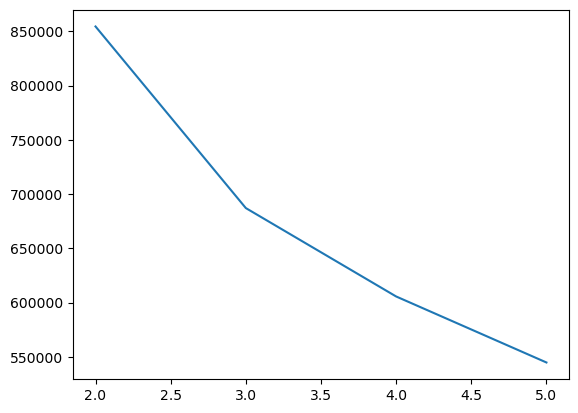

In [226]:
sns.lineplot(x = range(2,6), y = sse)
plt.show()

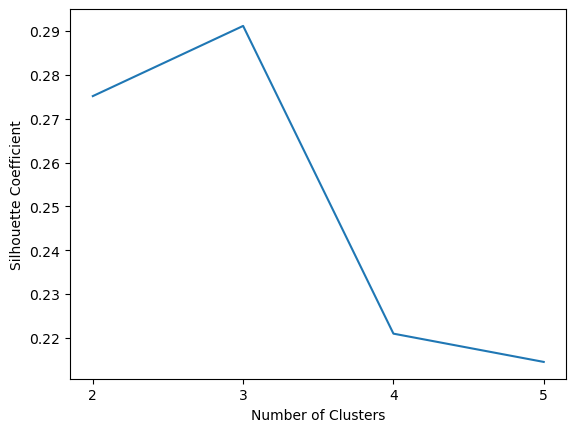

In [227]:
plt.plot(range(2, 6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Feature importance

We will select k = 3 since it holds the highest silhouette coeffiecient.

In [20]:
kmeans = KMeans(n_clusters = 3, **kmeans_kwargs)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=123)

We will make sure to store our model.

In [21]:
dump(kmeans, 'kmeansmodel.joblib');

In [22]:
features['labels'] = kmeans.labels_

Now we will compare each feature and hue them by the labels given by the kmeans algorithm.

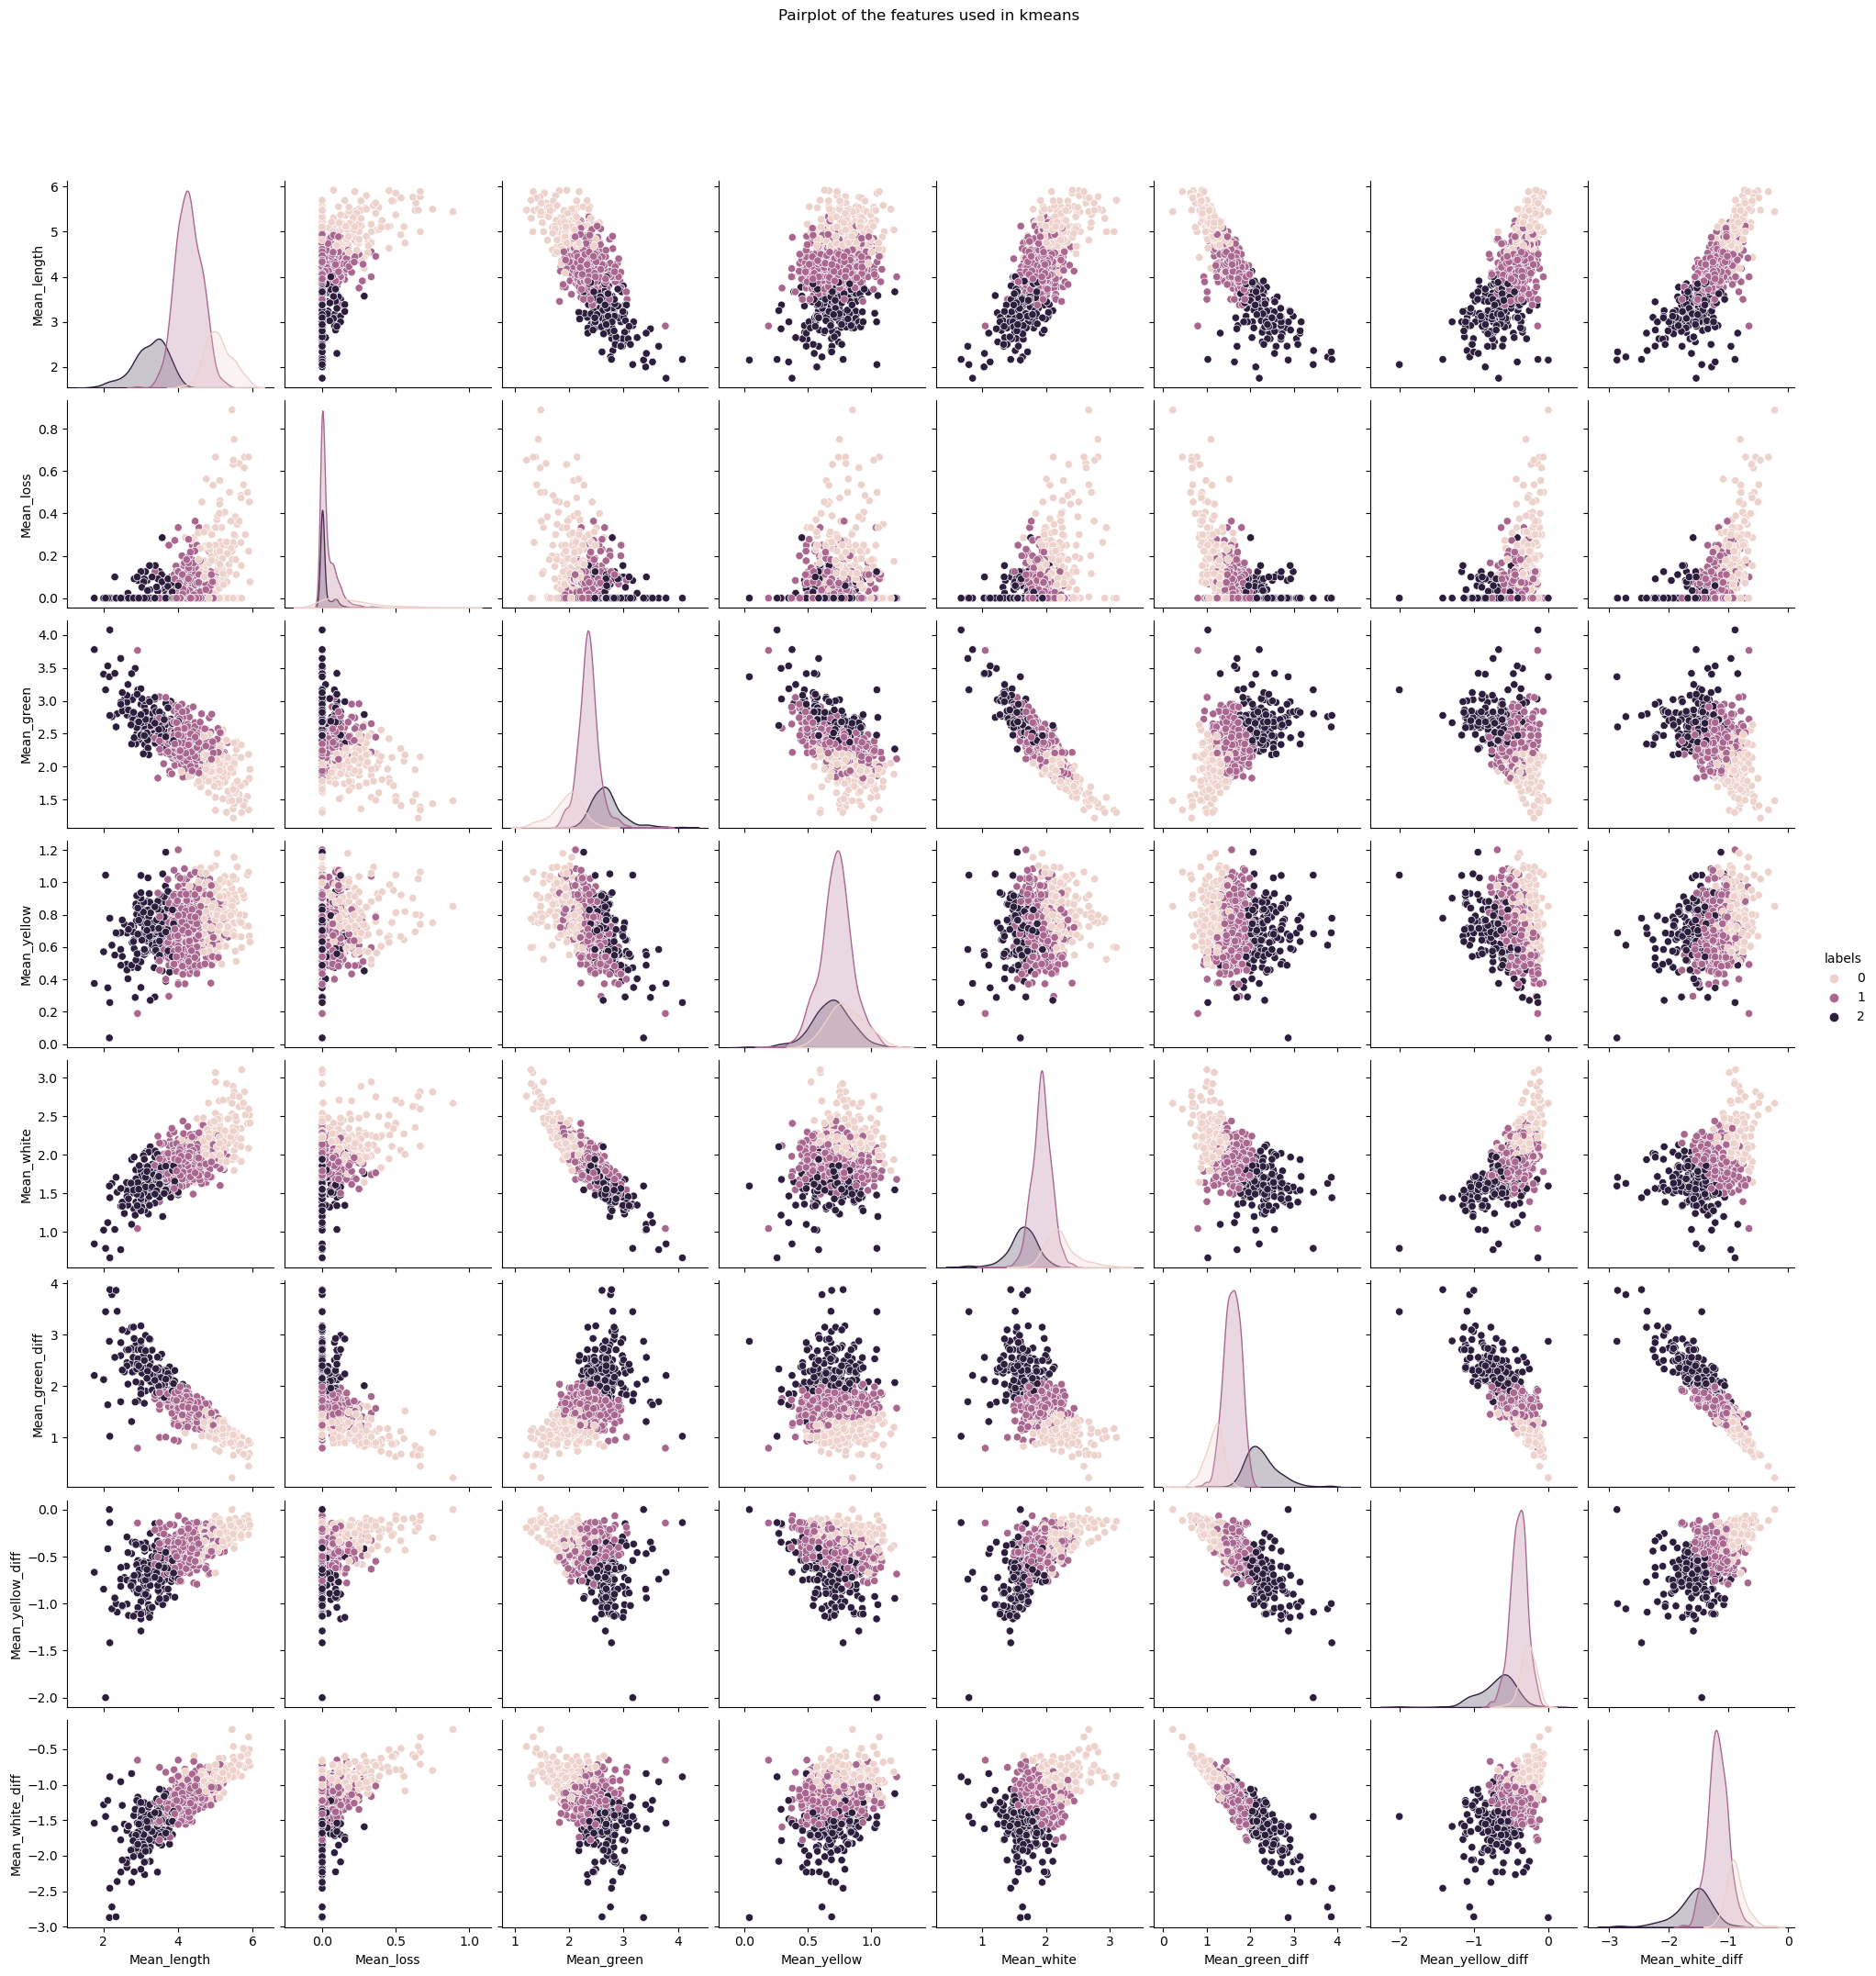

In [34]:
pair = sns.pairplot(data = features.sample(1000), hue = 'labels')
pair.fig.suptitle("Pairplot of the features used in kmeans", y=1.08) # y= some height>1
plt.show()

In [38]:
fig = px.scatter_3d(features.sample(500), x = 'Mean_white_diff', y = 'Mean_green_diff', 
                    z = 'Mean_yellow_diff', color = 'labels', title = 'Scatterplot of the mean difference')
fig.update_traces(marker_size = 5)
fig.show()

In [39]:
fig = px.scatter_3d(features.sample(500), x = 'Mean_white', y = 'Mean_green', 
                    z = 'Mean_yellow', color = 'labels',  title = 'Scatterplot of the average number of tiles')
fig.update_traces(marker_size = 5)
fig.show()